# Indicator Exploration

*Justin R. Garrard*

### *Executive Summary*



### *Objectives*



### Setup

In [11]:
# Import libraries
import os 
import math
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from ipywidgets import * 
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from scipy.cluster.hierarchy import dendrogram

In [2]:
# Declare global variables
DATA_DIR = os.path.join('../data/processed')
DATA_FILE = os.path.join(DATA_DIR, 'processed_features.csv')
plt.style.use('ggplot')

In [3]:
# Useful functions
def null_counter(df):
    record_nulls = []
    for col in df.columns:
        nulls = df[col].isnull().sum()
        percent_null = round((nulls / df.shape[0]) * 100, 2)
        record_nulls.append([col, nulls, percent_null])
    output = pd.DataFrame(record_nulls, columns=['Attribute', 'Null Count', '% Null'])
    return output

def get_year_range(df):
    year_range = list(df['year'].unique())
    year_range.sort()
    return year_range

def subset_by_states_only(df):
    df = df[df['fips'] <= 56]
    return df

def sound_off(df):
    nRow, nCol = cluster_df.shape
    print(f'There are {nRow} rows and {nCol} columns.')
    print('')

    YEAR_RANGE = get_year_range(cluster_df)
    print(f'Data spans the years {YEAR_RANGE[0]} to {YEAR_RANGE[-1]}.')
    print('')

    print('Available columns include:')
    display(null_counter(cluster_df))
    
def filter_out_factor(df, column_name):
    ## Identify records with null values in column
    bad_records = df[df[column_name].isnull()]
    bad_records.to_csv(f'missing_{column_name}.csv')

    ## Drop records with null values in column
    df = df[df[column_name].notnull()]
    return df

In [4]:
# Load and preview data
## Isolate by specific columns
cluster_df = pd.read_csv(DATA_FILE)

sound_off(cluster_df)

There are 116444 rows and 12 columns.

Data spans the years 2009 to 2016.

Available columns include:


,Attribute,Null Count,% Null
0,leaid,0,0.0
1,year,0,0.0
2,lea_name,0,0.0
3,fips,0,0.0
4,number_of_schools,0,0.0
5,teachers_total_fte,0,0.0
6,spec_ed_students,0,0.0
7,enrollment_x,0,0.0
8,read_test_pct_prof_midpt,0,0.0
9,math_test_pct_prof_midpt,0,0.0


In [5]:
# Remove the columns that won't be used as features
cluster_prepared_df = cluster_df.drop(['leaid', 'year', 'lea_name', 'fips'], axis=1)

### Modeling

In [7]:
# Build an elbow chart to find a good cluster range
def build_elbow_chart(df, min_clusters=2, max_clusters=10, random_seed=777):
    ## Calculate sum of squared distances for each cluster
    ssd = []
    for k in range(min_clusters, max_clusters+1):
        kmeans_learner = KMeans(n_clusters=k, random_state=random_seed)
        kmeans_learner.fit(df)
        ssd.append(kmeans_learner.inertia_)

    ## Plot sum of squared distances
    plt.plot(range(min_clusters, max_clusters+1), ssd)
    plt.title('Elbow Chart')
    plt.xlabel('K')
    plt.ylabel('Sum of Squared Distances')
    
    
# Build a good cluster and view the resulting data
def build_cluster(df, k=6, random_seed=777):
    kmeans_learner = KMeans(n_clusters=k, random_state=random_seed)
    results = kmeans_learner.fit_predict(df)
    return results


# View the characteristics of each labeled dataset
def view_cluster(df, results, k=6):
    df['labels'] = results
    for i in range(0, k):
        subset = df[df['labels'] == i]
        subset.to_csv(f'labeled_{i}.csv')
        print(i)
        display(subset.describe())
        print()

In [6]:
# Place data into four categories, to prevent clustering from emphasizing size
single_df = cluster_prepared_df[cluster_prepared_df['number_of_schools'] == 1]

small_df = cluster_prepared_df[(cluster_prepared_df['number_of_schools'] > 1) & 
                               (cluster_prepared_df['number_of_schools'] <= 3)]

medium_df = cluster_prepared_df[(cluster_prepared_df['number_of_schools'] > 3) & 
                               (cluster_prepared_df['number_of_schools'] <= 10)]

large_df = cluster_prepared_df[(cluster_prepared_df['number_of_schools'] > 10)]

df_list = [single_df, small_df, medium_df, large_df]
counts = [x['number_of_schools'].count() for x in df_list]
print(counts)

[27310, 37561, 38079, 13386]


In [9]:
# Normalize within clusters to detect patterns besides size
normed_df_list = []
for df in df_list:
        normed_df_list.append(preprocessing.StandardScaler().fit_transform(df))

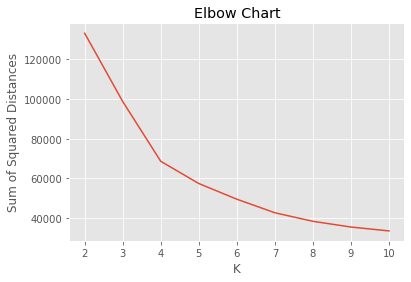

In [12]:
build_elbow_chart(normed_df_list[0])

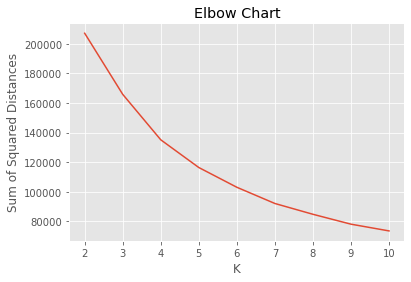

In [13]:
build_elbow_chart(normed_df_list[1])

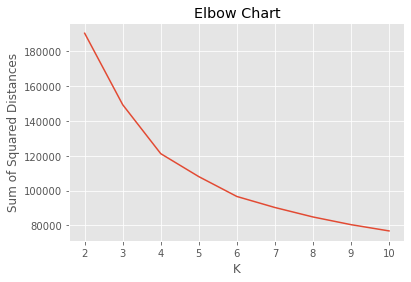

In [14]:
build_elbow_chart(normed_df_list[2])

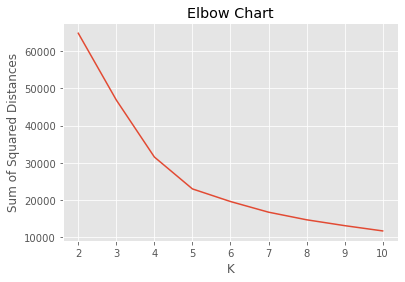

In [15]:
build_elbow_chart(normed_df_list[3])

In [16]:
results = []
for df in normed_df_list:
    results.append(build_cluster(df, k=4))

---
Analysis (Category)
---

In [28]:
# Box Plot

# Interactive Box Plot for Indicators
%matplotlib notebook

metrics = list(cluster_prepared_df.columns)
category = [0, 1, 2, 3]
category_mapping = {0: "Single", 1: "Small", 2: "Medium", 3: "Large"}

@interact(metric=metrics)
def cat_box_metric_explorer(metric):
    # Clear any old figures
    plt.close()
    
    # Make a plot to match states to the chosen metric
    plt.figure(figsize=(6, 4), num='Boxplot Explorer Tool')
    
    plot_data = [category_df[metric] for category_df in df_list]

    plt.boxplot(plot_data)
    plt.title(f'Category: {metric}')
    
interactive_plot = interactive(cat_box_metric_explorer,
                               metric=metrics[0])

interactive(children=(Dropdown(description='metric', options=('number_of_schools', 'teachers_total_fte', 'spec…

---
Analysis (Sub-Category)
---

In [26]:
# Box Plot

# Interactive Box Plot for Indicators
%matplotlib notebook

metrics = list(cluster_prepared_df.columns)
category = [0, 1, 2, 3]
category_mapping = {0: "Single", 1: "Small", 2: "Medium", 3: "Large"}

@interact(metric=metrics, cat=category)
def box_metric_explorer(metric, cat):
    # Clear any old figures
    plt.close()
    
    # Make a plot to match states to the chosen metric
    plt.figure(figsize=(6, 4), num='Boxplot Explorer Tool')
    
    # Select category data
    cluster_count = len(np.unique(results[cat]))
    category_df = df_list[cat]
    view_cluster(category_df, results[cat], k=cluster_count)
    
    # Subset sub-categories
    sub_categories = [category_df[category_df['labels'] == i] for i in range(0,cluster_count)]
    
    # Subset metric
    plot_data = [sub_df[metric] for sub_df in sub_categories]

    plt.boxplot(plot_data)
    plt.title(f'{category_mapping[cat]} Category: {metric}')
    
interactive_plot = interactive(box_metric_explorer,
                               metric=metrics[0],
                               cat=category[0])

interactive(children=(Dropdown(description='metric', options=('number_of_schools', 'teachers_total_fte', 'spec…